In [37]:
import pathlib
import datetime
import warnings

from tqdm.notebook import tqdm

import shapely.geometry
import geopandas as gpd
import pandas as pd
import numpy as np
import movingpandas as mpd
import matplotlib.pyplot as plt
import matplotlib.colors
import datashader as ds

warnings.filterwarnings('ignore')

In [2]:
data_dir = pathlib.Path('~/data/drought/ivs').expanduser()


In [3]:

path = data_dir / 'traj.geojson'

In [41]:
trips_gdf = gpd.read_file(data_dir / 'trip_metadata.geojson')
trips_gdf = trips_gdf.set_index('traj_id')

In [4]:
traj_gdf = gpd.read_file(path)
min_lon, min_lat, max_lon, max_lat = traj_gdf.total_bounds

traj_gdf = traj_gdf.to_crs('EPSG:3857')


In [52]:
min_lon, min_lat, max_lon, max_lat


(3.98679867212126, 48.80085112523804, 9.2593000000002, 52.47341491974)

In [62]:
min_x, min_y, max_x, max_y = traj_gdf.total_bounds
min_x, min_y, max_x, max_y



(443808.3980758379, 6241137.306100557, 1030740.5611021803, 6886181.785092141)

In [6]:
trajs = mpd.TrajectoryCollection(
    traj_gdf.set_index('t'), 
    traj_id_col='traj'
)

In [7]:
t_min, t_max = traj_gdf.t.min(), traj_gdf.t.max()
t_min, t_max

(Timestamp('2022-01-02 00:32:13.079000'),
 Timestamp('2022-10-02 10:45:55.248000'))

In [81]:
timestamps = pd.date_range(t_min, t_max, freq='10min')
t_df = pd.DataFrame(data=dict(t0=timestamps))
t_df.tail()

,t0
39369,2022-10-02 10:02:13.079
39370,2022-10-02 10:12:13.079
39371,2022-10-02 10:22:13.079
39372,2022-10-02 10:32:13.079
39373,2022-10-02 10:42:13.079


In [82]:
t_df['t1'] = timestamps + datetime.timedelta(hours=2)

  0%|          | 0/39374 [00:00<?, ?it/s]

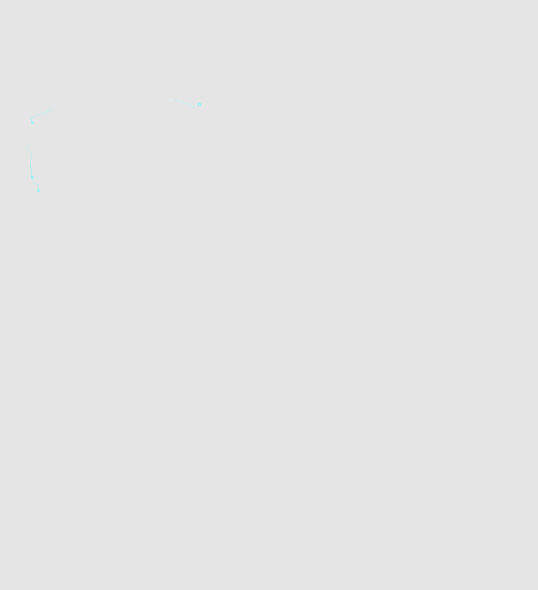

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('tight')
ax.axis('off')
# work around bug in mapbox-gl
fig.patch.set_facecolor((0, 0, 0, 0.1))

lading_N = matplotlib.colors.Normalize(0, 2000, clip=True)

for i, t_df_i in tqdm(t_df.iterrows(), total=t_df.shape[0]):
    if i > 1000:
        break
    ax.clear()
    # ax.axis('tight')
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


    for traj_i in trajs.trajectories:
        t0, t1 = t_df_i
        if traj_i.get_start_time() > t1:
            # traj starts after selection
            continue
        if traj_i.get_end_time() < t0:
            # traj stops before selection
            continue
        pos = traj_i.get_position_at(t1)
        try:
            segment = traj_i.get_segment_between(t0, t1)
            segment.plot(alpha=0.5, edgecolor='cyan', linewidth=0.3, ax=ax)
            segment.plot(alpha=0.2, edgecolor='white', linewidth=0.3, ax=ax)
        except ValueError:
            pass

        trip_info = trips_gdf.loc[traj_i.id]
        markersize = lading_N(trip_info['lading']) * 3 + 1
        ax.plot(pos.x, pos.y, 'o', color='cyan', alpha=0.3, markersize=markersize)
        ax.plot(pos.x, pos.y, 'o', color='white', alpha=0.3, markersize=markersize / 2)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    fig.savefig(f'render-{i:04d}.png', dpi=250)


In [ ]:
!ffmpeg -i 'render-%04d.png'  -c:v libvpx-vp9 -b:v 2M -cpu-used -5 -deadline realtime  render.webm